In [ ]:
#basic libraries
import os
import numpy as np
import cv2
import glob

#machine learning libraries
import tensorflow as tf
import glob2
from sklearn.model_selection import train_test_split
import keras
from keras import layers
from keras import models
from keras import callbacks
from keras.layers import Conv2D,BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate,Input
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

#plotting library

import matplotlib.pyplot as plt

In [ ]:
#sets up a consistent training environment

os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#parameters

batch_size = 16
lr = 1e-4 ## 0.0001 #learning rate
epochs = 20

#img dimensions
height = 256
width =512

# Data Preprocessing

In [ ]:
dataset_path = '/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Childrens dental caries segmentation dataset'
files_dir = "/kaggle/working/"
model_file = os.path.join(files_dir, "unet-model.h5.keras")
log_file = os.path.join(files_dir, "unet-log.csv")

def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)
create_dir(files_dir)

# Model Building

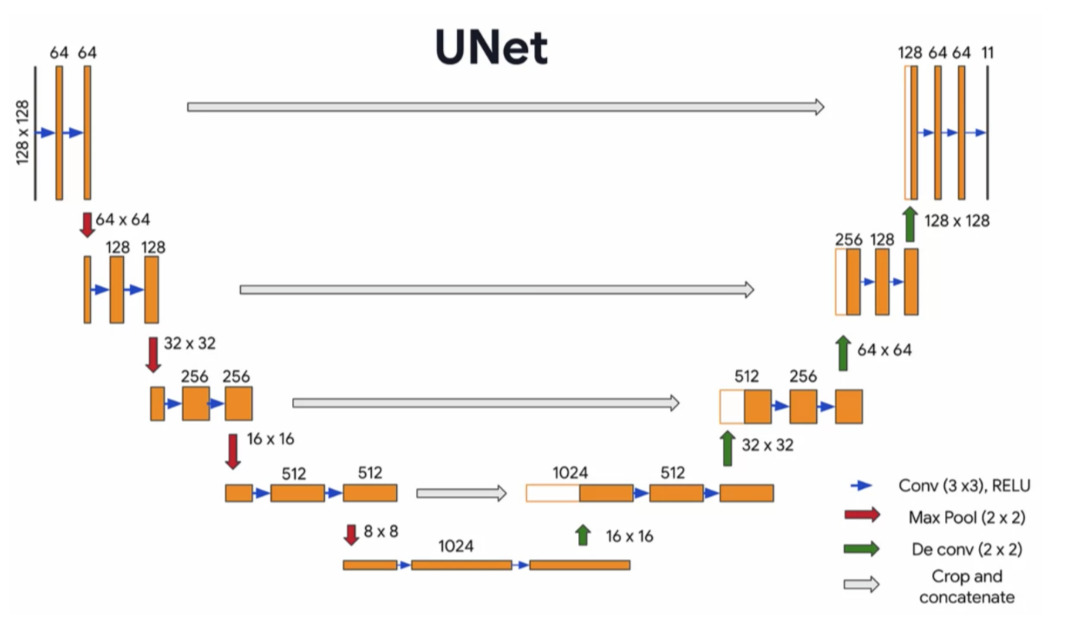

In [ ]:

#each conv block has 2 conv layers
def conv_block(inputs,num_filters):
  x = Conv2D(num_filters,3,padding="same")(inputs)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters,3,padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  return x

# feature extraction done by encoder block

def encoder_block(inputs,num_filters):
  x = conv_block(inputs,num_filters)
  p = MaxPool2D((2,2))(x)
  return x,p

# feature extraction done by encoder block

def decoder_block(inputs,skip,num_filters):

  x = Conv2DTranspose(num_filters,(2,2), strides=2, padding="same")(inputs)
  x = Concatenate()([x,skip])
  x = conv_block(x,num_filters)
  return x

def build_unet(input_shape):
  inputs = Input(input_shape)
  s1, p1 = encoder_block(inputs,64)
  s2, p2 = encoder_block(p1,128)
  s3, p3 = encoder_block(p2,256)
  s4, p4 = encoder_block(p3,512)

  """Bridge"""
  b1 = conv_block(p4,1024)

  """Decoder"""
  d1 = decoder_block(b1,s4,512)
  d2 = decoder_block(d1,s3,256)
  d3 = decoder_block(d2,s2,128)
  d4 = decoder_block(d3,s1,64)

  outputs = Conv2D(1,1, padding="same", activation="sigmoid")(d4)

  model = Model(inputs,outputs,name="UNET")
  return model



In [ ]:
#img_path=glob.glob('/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Childrens dental caries segmentation dataset')
#mask_path=glob.glob('/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Childrens dental caries segmentation dataset')

def load_data(path):
  train_x = sorted(glob2.glob(os.path.join(path, "Train", "images", "*")))
  train_y = sorted(glob2.glob(os.path.join(path, "Train", "mask", "*")))

  valid_x = sorted(glob2.glob(os.path.join(path, "Test", "images", "*")))
  valid_y = sorted(glob2.glob(os.path.join(path, "Test", "mask", "*")))


  return (train_x,train_y), (valid_x, valid_y)

In [ ]:
def read_image(path):
  path = path.decode()
  x = cv2.imread(path,cv2.IMREAD_COLOR)
  x = x/255.0
  x=cv2.resize(x, (width,height))
  return x



def read_mask(path):
  path = path.decode()
  x = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
  x = x/255.0
  x=cv2.resize(x, (width, height))
  x = np.expand_dims(x,axis=-1)
  return x

In [ ]:
def tf_parse(x,y):
  def _parse(x,y):
    x = read_image(x)
    y = read_mask(y)
    return x,y

  x,y = tf.numpy_function(_parse,[x,y],[tf.float64,tf.float64])
  x.set_shape([height,width,3])
  y.set_shape([height,width,1])

  return x,y

In [ ]:
def tf_dataset(x,y, batch=8):
  dataset = tf.data.Dataset.from_tensor_slices((x,y))
  dataset = dataset.map(tf_parse,num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.batch(batch)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  return dataset

In [ ]:
(train_x, train_y), (valid_x, valid_y) = load_data(dataset_path)
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

Train: 0 - 0
Valid: 0 - 0


In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [ ]:
for x, y in train_dataset:
  print(x.shape, y.shape) #x.shape

(4, 256, 512, 3) (4, 256, 512, 1)
(4, 256, 512, 3) (4, 256, 512, 1)
(4, 256, 512, 3) (4, 256, 512, 1)
(4, 256, 512, 3) (4, 256, 512, 1)
(4, 256, 512, 3) (4, 256, 512, 1)
(4, 256, 512, 3) (4, 256, 512, 1)
(4, 256, 512, 3) (4, 256, 512, 1)
(4, 256, 512, 3) (4, 256, 512, 1)
(4, 256, 512, 3) (4, 256, 512, 1)
(4, 256, 512, 3) (4, 256, 512, 1)
(4, 256, 512, 3) (4, 256, 512, 1)
(4, 256, 512, 3) (4, 256, 512, 1)
(4, 256, 512, 3) (4, 256, 512, 1)
(4, 256, 512, 3) (4, 256, 512, 1)
(4, 256, 512, 3) (4, 256, 512, 1)
(4, 256, 512, 3) (4, 256, 512, 1)
(4, 256, 512, 3) (4, 256, 512, 1)
(2, 256, 512, 3) (2, 256, 512, 1)


In [ ]:
input_shape = (height, width, 3)
model = build_unet(input_shape)
model.summary()

Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 512,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 512,  │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 256, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 512,  │     36,928 │ activation_18[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 512,  │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 256, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 256,  │          0 │ activation_19[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 256,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 256,  │        512 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 128, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 256,  │    147,584 │ activation_20[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 256,  │        512 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 128, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 128,   │          0 │ activation_21[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 128,   │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │      1,024 │ conv2d_23[0][0] 

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
opt = keras.optimizers.Adam(lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["acc"]) #adam optimiser, binary crossentropy loss functions, metrics accuracy

In [ ]:
callbacks = [ModelCheckpoint(model_file, verbose=1, save_best_only=True),                     #saves progress
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),                   #reduces learning rate when training doesnt improve
             CSVLogger(log_file),                                                             #keeps track of accuracy, makes metric log
             EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)       #early stop kore jokhon validation loss ar change hoyna
             ]

In [ ]:
model.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/20


I0000 00:00:1731506452.187493     252 service.cc:145] XLA service 0x7e4d50725870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731506452.187612     252 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731506452.187619     252 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1731506494.646254     252 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.4042 - loss: 0.7631   
Epoch 1: val_loss improved from inf to 0.69242, saving model to /kaggle/working/unet-model.h5.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - acc: 0.4130 - loss: 0.7571 - val_acc: 0.3881 - val_loss: 0.6924 - learning_rate: 1.0000e-04
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - acc: 0.8187 - loss: 0.4290
Epoch 2: val_loss improved from 0.69242 to 0.65668, saving model to /kaggle/working/unet-model.h5.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 614ms/step - acc: 0.8191 - loss: 0.4277 - val_acc: 0.8020 - val_loss: 0.6567 - learning_rate: 1.0000e-04
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - acc: 0.8313 - loss: 0.3403
Epoch 3: val_loss improved from 0.65668 to 0.59011, saving model to /kaggle/working/unet-model.h5.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 609ms/step - acc: 0.8314 - loss: 0.3397 - val_acc: 0.8187 - val_loss: 0.5901 - learning_rate: 1.0000e-04
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - a

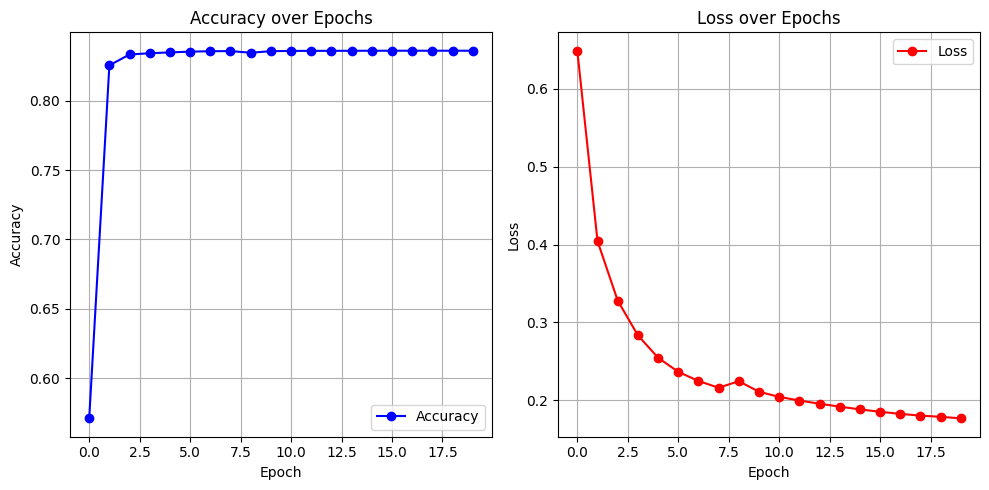

NameError: name 'Explanation' is not defined

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Step 1: Load the CSV file
csv_file = '/content/drive/MyDrive/424_Project/UNET/unet-log.csv'
data = pd.read_csv(csv_file)

# Step 2: Extract data
epochs = data['epoch']
accuracy = data['acc']
loss = data['loss']

# Step 3: Plot accuracy and loss
plt.figure(figsize=(10, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, marker='o', label='Accuracy', color='blue')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, marker='o', label='Loss', color='red')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

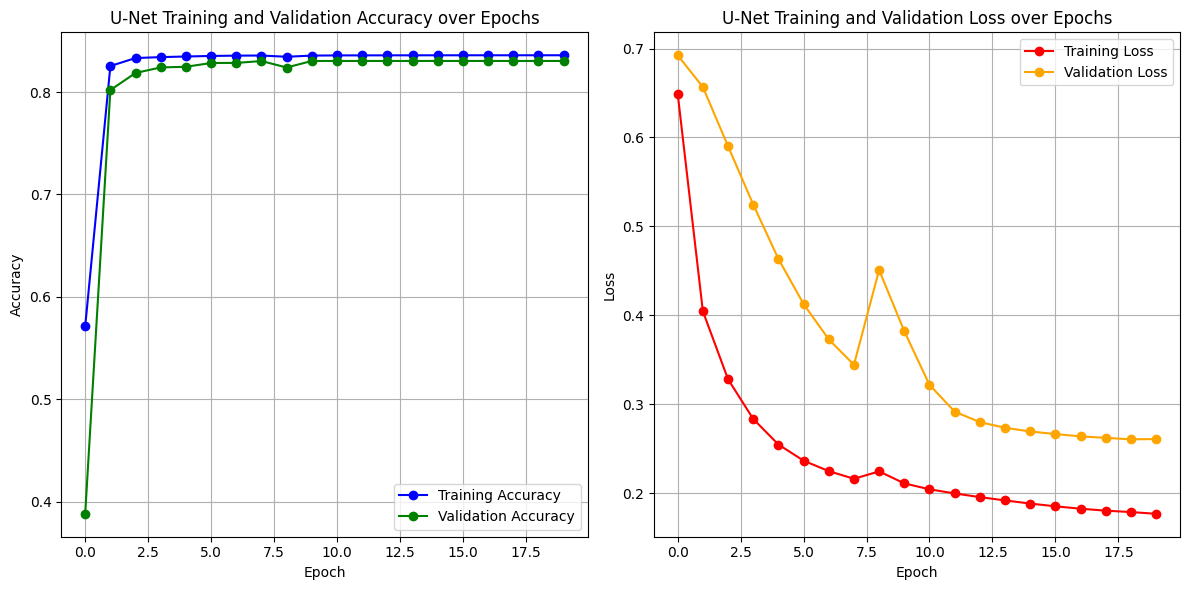

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the CSV file
csv_file = '/content/drive/MyDrive/424_Project/UNET/unet-log.csv'
data = pd.read_csv(csv_file)

# Step 2: Extract data
epochs = data['epoch']
accuracy = data['acc']
loss = data['loss']
train_acc = data['acc']
val_acc = data['val_acc']
val_loss = data['val_loss']

# Step 3: Plot accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, marker='o', label='Training Accuracy', color='blue')
plt.plot(epochs, val_acc, marker='o', label='Validation Accuracy', color='green')
plt.title('U-Net Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, marker='o', label='Training Loss', color='red')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss', color='orange')
plt.title('U-Net Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Evaluate the ResNet-50 model
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['validation_accuracy'])
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()



NameError: name 'history' is not defined

<Figure size 640x480 with 0 Axes>